In [1]:
%run '/mnt/berger2/equipes/IGE/meom/workdir/berger2/fonctions/meom_fonctions/fonctions.ipynb'

import numpy as np
import matplotlib.pyplot as plt
import scipy.io.netcdf as netcdf
import qgutils as qg
from matplotlib import ticker, cm
plt.ion()

In [2]:
#paramètres gravés dans le marbre pour le stage

Delta = 10000                               #grid spacing
f0 = 9.37456E-05                           #paramètre de Coriolis
dh = np.array([350,750,2900])              #hauteurs des couches océaniques
dh_b = np.array([(dh[0]+dh[1])/2,(dh[2]+dh[1])/2])
g_prime = np.array([2.5E-02,1.25E-02])     #gravités réduites aux interfaces
Beta = 1.75360E-11
delta_ek = 5                               #ocean bottom Ekman thickness 
nu4 = 2E09                                 #bi-harmonic viscosity
Ht = np.sum(dh)
Ht_b = np.sum(dh_b)
toc = np.array([1.31693E+01,1.81693E+01,2.41693E+01])
bf = delta_ek*f0/(2*dh[-1])

#fréquences Brunt-vaisala

N_12 = g_prime[0]/((dh[0]+dh[1])/2)
N_23 = g_prime[1]/((dh[1]+dh[2])/2)
N2 = np.array([N_12,N_23])

In [3]:
dir0  = '/mnt/berger2/equipes/IGE/meom/workdir/berger2/qgcm-data/double_gyre_coupled/outdata_7_dt10/'
dir1  = '/mnt/berger2/equipes/IGE/meom/workdir/berger2/qgcm-data/double_gyre_coupled/outdata_6tdiff_dt10/'
file0 = 'ocpo.nc'
file1 = 'ocsst.nc'

In [4]:
#get fields psi
pfile_abs = dir0 + file0
pfile_rel = dir1 + file0

f1 = netcdf.netcdf_file(dir0 + file0,'r')

si_t = f1.variables['time'][:].copy().size

In [5]:
print(si_t)

731


In [6]:
#termes
p_abs = qg.read_qgcm(pfile_abs, 0, var='p', rescale = 1/f0, interp = True, subtract_bc = True)
p_rel = qg.read_qgcm(pfile_rel, 0, var='p', rescale = 1/f0, interp = True, subtract_bc = True)

p_abs = p_abs[0]
p_rel = p_rel[0]

In [11]:
#get shapes
k,fl = qg.get_spec_flux(psi1 = p_abs, psi2 = p_abs, Delta=Delta)
#fl_z = integral_z(psi = fl, dh=dh, Delta=Delta, Ht=Ht)
n_k = fl.shape

In [15]:
%%time
fl_adv_i_me_abs = np.zeros((n_k))
fl_adv_i_me_rel = np.zeros((n_k))
n_me = 1


for it in range(0,si_t):
    
    p_abs = qg.read_qgcm(pfile_abs, it, var='p', rescale = 1/f0, interp = True, subtract_bc = True)
    p_rel = qg.read_qgcm(pfile_rel, it, var='p', rescale = 1/f0, interp = True, subtract_bc = True)
    
    gam_abs = qg.p2stretch(p_abs,dh,N2,f0)
    gam_rel = qg.p2stretch(p_rel,dh,N2,f0)
    
#    p_abs = p_abs_all[0,:,:]
#    p_rel = p_rel_all[0,:,:]

    z_abs = qg.laplacian(p_abs,Delta)
    z_rel = qg.laplacian(p_rel,Delta)

    jac_pe_abs = qg.jacobian(p_abs, gam_abs, Delta)
    jac_pe_rel = qg.jacobian(p_rel, gam_rel, Delta)
    
    
    k_adv_abs, fl_adv_abs = qg.get_spec_flux(psi1 =p_abs ,psi2 = jac_pe_abs , Delta=Delta )
    k_adv_rel, fl_adv_rel = qg.get_spec_flux(psi1 =p_rel ,psi2 = jac_pe_rel , Delta=Delta )

    fl_adv_i_abs = integral_z(fl_adv_abs, dh=dh, Delta=Delta, Ht = Ht)
    fl_adv_i_rel = integral_z(fl_adv_rel, dh=dh, Delta=Delta, Ht = Ht)
    
    fl_adv_i_me_abs += (fl_adv_i_abs - fl_adv_i_me_abs)/n_me
    fl_adv_i_me_rel += (fl_adv_i_rel - fl_adv_i_me_rel)/n_me
    
    n_me += 1

CPU times: user 1h 36min 14s, sys: 22.1 s, total: 1h 36min 36s
Wall time: 1h 42min 43s


In [16]:
def forward(x):
    return 1/x

def inverse(x):
    return 1/x

<ipython-input-16-711fb66c38b2>:5: RuntimeWarning: divide by zero encountered in true_divide
  return 1/x


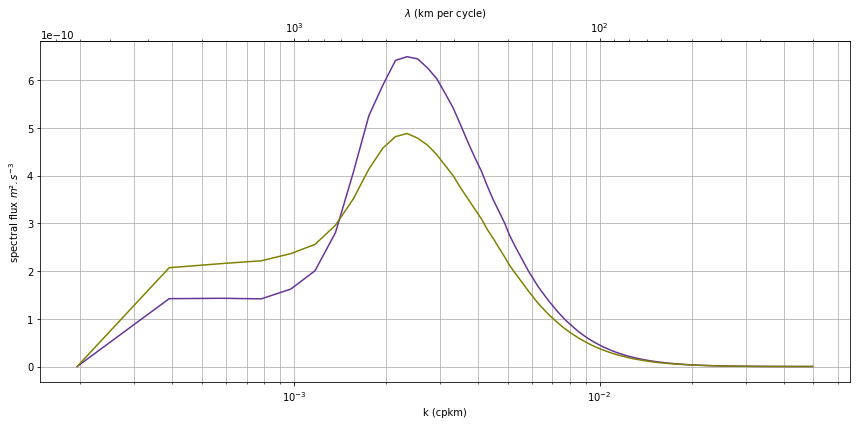

In [18]:
#plot average
fl_adv_me_abs_int = integral_z(fl_adv_i_me_abs, dh=dh, Delta=Delta, Ht = Ht)
fl_adv_me_rel_int = integral_z(fl_adv_i_me_rel, dh=dh, Delta=Delta, Ht = Ht)

fig, ax2 = plt.subplots(1, 1, figsize = (12,6),tight_layout=True)


ax2.plot(k_adv_abs*1e3, fl_adv_me_abs_int, color = 'rebeccapurple')
ax2.plot(k_adv_rel*1e3, fl_adv_me_rel_int, color = 'olive')
#ax2.set_title('bottom drag')
ax2.set_xlabel('k (cpkm)')
ax2.set_ylabel(r'spectral flux $m².s^{-3}$')#($m².s^{-2}.(rad.km^{-1})^{-1}$)')
ax2.set_xscale('log')
#ax1.xaxis.set_major_locator(plt.MultipleLocator(0.001))
#ax1.xaxis.set_minor_locator(plt.MultipleLocator(0.00025))
secax2 = ax2.secondary_xaxis('top', functions = (forward, inverse))
secax2.set_xlabel(r'$\lambda$ (km per cycle)')
ax2.grid(True, which = 'both')

#savefig
plt.savefig('/mnt/berger2/equipes/IGE/meom/workdir/berger2/git/meom_test/Lorenz_cycle/figs_spectres/advection/advec_pe_me.png')

In [ ]:
#plot snapshot


fig, ax2 = plt.subplots(1, 1, figsize = (12,6),tight_layout=True)


ax2.plot(k_adv_abs*1e3, fl_adv_abs, color = 'rebeccapurple')
ax2.plot(k_adv_rel*1e3, fl_adv_rel, color = 'olive')
#ax2.set_title('bottom drag')
ax2.set_xlabel('k (cpkm)')
ax2.set_ylabel(r'spectral flux $m².s^{-3}$')#($m².s^{-2}.(rad.km^{-1})^{-1}$)')
ax2.set_xscale('log')
#ax1.xaxis.set_major_locator(plt.MultipleLocator(0.001))
#ax1.xaxis.set_minor_locator(plt.MultipleLocator(0.00025))
secax2 = ax2.secondary_xaxis('top', functions = (forward, inverse))
secax2.set_xlabel(r'$\lambda$ (km per cycle)')
ax2.grid(True, which = 'both')

#savefig
plt.savefig('/mnt/berger2/equipes/IGE/meom/workdir/berger2/git/meom_test/Lorenz_cycle/figs_spectres/advection/advec_snap.png')